In [1]:
import time
import numpy as np
import torch
import torchvision
from torchmps import MPS
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['text.usetex'] = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Miscellaneous initialization
torch.manual_seed(0)

# functions to show an image
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# functions to load data
def load_data(dataset):
    # Get the training and test sets
    transform = transforms.ToTensor()
    # transform = transforms.Compose(
    #     [transforms.ToTensor(),
    #      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
    print("=====================================")
    print("The dataset we are training:", dataset)
    if  dataset == 'mnist':
        train_set = datasets.MNIST('./mnist', download=True, transform=transform)
        test_set = datasets.MNIST('./mnist', download=True, transform=transform, train=False)
    elif dataset == 'fashionmnist':
        train_set = datasets.FashionMNIST('./fashionmnist', download=True, transform=transform)
        test_set = datasets.FashionMNIST('./fashionmnist', download=True, transform=transform, train=False)
    elif dataset == 'cifar':
        train_set = datasets.CIFAR10('./CIFAR10', download=True, transform=transform)
        test_set = datasets.CIFAR10('./CIFAR10', download=True, transform=transform, train=False)

    # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # print(len(train_set))
    dim = len(train_set[1][0][0])
    num_channel = len(train_set[1][0])

    # Put MNIST data into dataloaders
    samplers = {'train': torch.utils.data.SubsetRandomSampler(range(num_train)),
                'test': torch.utils.data.SubsetRandomSampler(range(num_test))}
    loaders = {name: torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
               sampler=samplers[name], drop_last=True) for (name, dataset) in 
               [('train', train_set), ('test', test_set)]}
    num_batches = {name: total_num // batch_size for (name, total_num) in
                   [('train', num_train), ('test', num_test)]}

    print(f"Training on {num_train} images \n"
          f"(testing on {num_test}) for {num_epochs} epochs")
    print(f"Maximum MPS bond dimension = {bond_dim}")
    print(f" * {'Adaptive' if adaptive_mode else 'Fixed'} bond dimensions")
    print(f" * {'Periodic' if periodic_bc else 'Open'} boundary conditions")
    print(f"Using Adam w/ learning rate = {learn_rate:.1e}")
    if l2_reg > 0:
        print(f" * L2 regularization = {l2_reg:.2e}")
    print()
#     print(np.size(train_set[1]))
          
    return samplers, loaders, num_batches, dim, num_channel
          
# Let's start training!
def mps_train(loaders, num_channel):
    # Initialize the MPS module
    mps = MPS(input_dim=dim**2, output_dim=10, bond_dim=bond_dim, 
              adaptive_mode=adaptive_mode, periodic_bc=periodic_bc)

    # Set our loss function and optimizer
    loss_fun = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mps.parameters(), lr=learn_rate, 
                                 weight_decay=l2_reg)

    if num_channel == 3:
        size = [num_channel, batch_size, dim**2]
    else:
        size = [batch_size, dim**2]
          
          
    train_acc = []
    test_acc  = []
    ave_loss = []
    run_time = []
          
    for epoch_num in range(1, num_epochs+1):
        running_loss = 0.
        running_acc = 0.

        for inputs, labels in loaders['train']:
            inputs, labels = inputs.view(size), labels.data

            # Call our MPS to get logit scores and predictions
            scores = mps(inputs)
            _, preds = torch.max(scores, 1)

            # Compute the loss and accuracy, add them to the running totals
            loss = loss_fun(scores, labels)
            with torch.no_grad():
                accuracy = torch.sum(preds == labels).item() / batch_size
                running_loss += loss
                running_acc += accuracy

            # Backpropagate and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"### Epoch {epoch_num} ###")
        print(f"Average loss:           {running_loss / num_batches['train']:.4f}")
        train_acc = train_acc + [ running_acc / num_batches['train'] ]
        print(f"Average train accuracy: {running_acc / num_batches['train']:.4f}")
        ave_loss = ave_loss + [ running_loss / num_batches['train'] ]

        # Evaluate accuracy of MPS classifier on the test set
        with torch.no_grad():
            running_acc = 0.
              
            for inputs, labels in loaders['test']:
                inputs, labels = inputs.view(size), labels.data

                # Call our MPS to get logit scores and predictions
                scores = mps(inputs)
                _, preds = torch.max(scores, 1)
                running_acc += torch.sum(preds == labels).item() / batch_size

        print(f"Test accuracy:          {running_acc / num_batches['test']:.4f}")
        test_acc = test_acc + [ running_acc / num_batches['test'] ]
        print(f"Runtime so far:         {int(time.time()-start_time)} sec\n")
        run_time = run_time + [ int(time.time()-start_time) ]
#         print(test_acc)
              
    return run_time, ave_loss, train_acc, test_acc

  0%|          | 16384/9912422 [00:00<01:14, 133022.60it/s]

The dataset we are training: mnist


9920512it [00:00, 34210494.73it/s]                           


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


32768it [00:00, 713260.89it/s]
  6%|▌         | 98304/1648877 [00:00<00:01, 913970.70it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:00, 8951887.78it/s]                          
8192it [00:00, 296787.98it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw
Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
Training on 2000 images 
(testing on 1000) for 15 epochs
Maximum MPS bond dimension = 20
 * Fixed bond dimensions
 * Open boundary conditions
Using Adam w/ learning rate = 1.0e-04



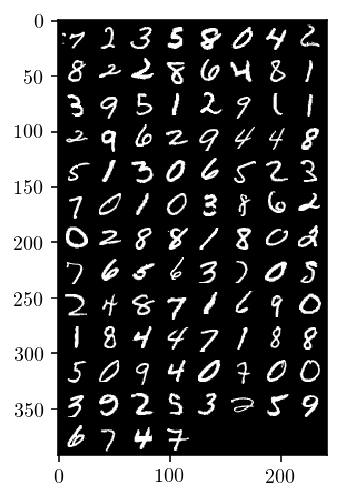

### Epoch 1 ###
Average loss:           2.2815
Average train accuracy: 0.1195
Test accuracy:          0.2100
Runtime so far:         30 sec

### Epoch 2 ###
Average loss:           2.1505
Average train accuracy: 0.2260
Test accuracy:          0.3510
Runtime so far:         58 sec

### Epoch 3 ###
Average loss:           1.6163
Average train accuracy: 0.4020
Test accuracy:          0.4950
Runtime so far:         87 sec

### Epoch 4 ###
Average loss:           1.2127
Average train accuracy: 0.5850
Test accuracy:          0.6620
Runtime so far:         115 sec

### Epoch 5 ###
Average loss:           0.7740
Average train accuracy: 0.7735
Test accuracy:          0.7450
Runtime so far:         143 sec

### Epoch 6 ###
Average loss:           0.5472
Average train accuracy: 0.8300
Test accuracy:          0.7990
Runtime so far:         172 sec

### Epoch 7 ###
Average loss:           0.4090
Average train accuracy: 0.8775
Test accuracy:          0.8390
Runtime so far:         200 sec

### Epoch

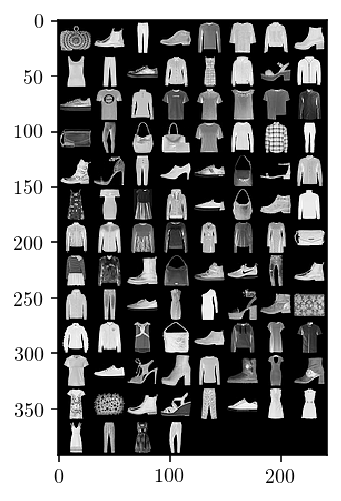

### Epoch 1 ###
Average loss:           2.1488
Average train accuracy: 0.2205
Test accuracy:          0.3300
Runtime so far:         28 sec

### Epoch 2 ###
Average loss:           1.2258
Average train accuracy: 0.5055
Test accuracy:          0.6190
Runtime so far:         57 sec

### Epoch 3 ###
Average loss:           0.8942
Average train accuracy: 0.6555
Test accuracy:          0.6970
Runtime so far:         85 sec

### Epoch 4 ###
Average loss:           0.7382
Average train accuracy: 0.7230
Test accuracy:          0.7200
Runtime so far:         114 sec

### Epoch 5 ###
Average loss:           0.6864
Average train accuracy: 0.7405
Test accuracy:          0.7560
Runtime so far:         143 sec

### Epoch 6 ###
Average loss:           0.5914
Average train accuracy: 0.7660
Test accuracy:          0.7470
Runtime so far:         171 sec

### Epoch 7 ###
Average loss:           0.5472
Average train accuracy: 0.7860
Test accuracy:          0.7640
Runtime so far:         200 sec

### Epoch

In [2]:
# MPS parameters
bond_dim      = 20
adaptive_mode = False
periodic_bc   = False

# Training parameters
num_train  = 2000
num_test   = 1000
batch_size = 100
num_epochs = 15
learn_rate = 1e-4
l2_reg     = 0.

# choose dataset
# data    = 'mnist'
# data    = 'fashionmnist'
# data    = 'cifar'

TRAIN_ACC = []
TEST_ACC  = []
AVE_LOSS = []
RUN_TIME = []

for data in ['mnist', 'fashionmnist']:
    start_time = time.time()
    samplers, loaders, num_batches, dim, num_channel = load_data(data)

    # visualization
    # get some random training images
    dataiter = iter(loaders['train'])
    images, labels = dataiter.next()
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    # print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

    # training
    run_time, ave_loss, train_acc, test_acc = mps_train(loaders, num_channel)
    TRAIN_ACC = TRAIN_ACC + [train_acc]
    TEST_ACC  = TEST_ACC  + [test_acc]
    AVE_LOSS  = AVE_LOSS  + [ave_loss]
    RUN_TIME  = RUN_TIME  + [run_time]


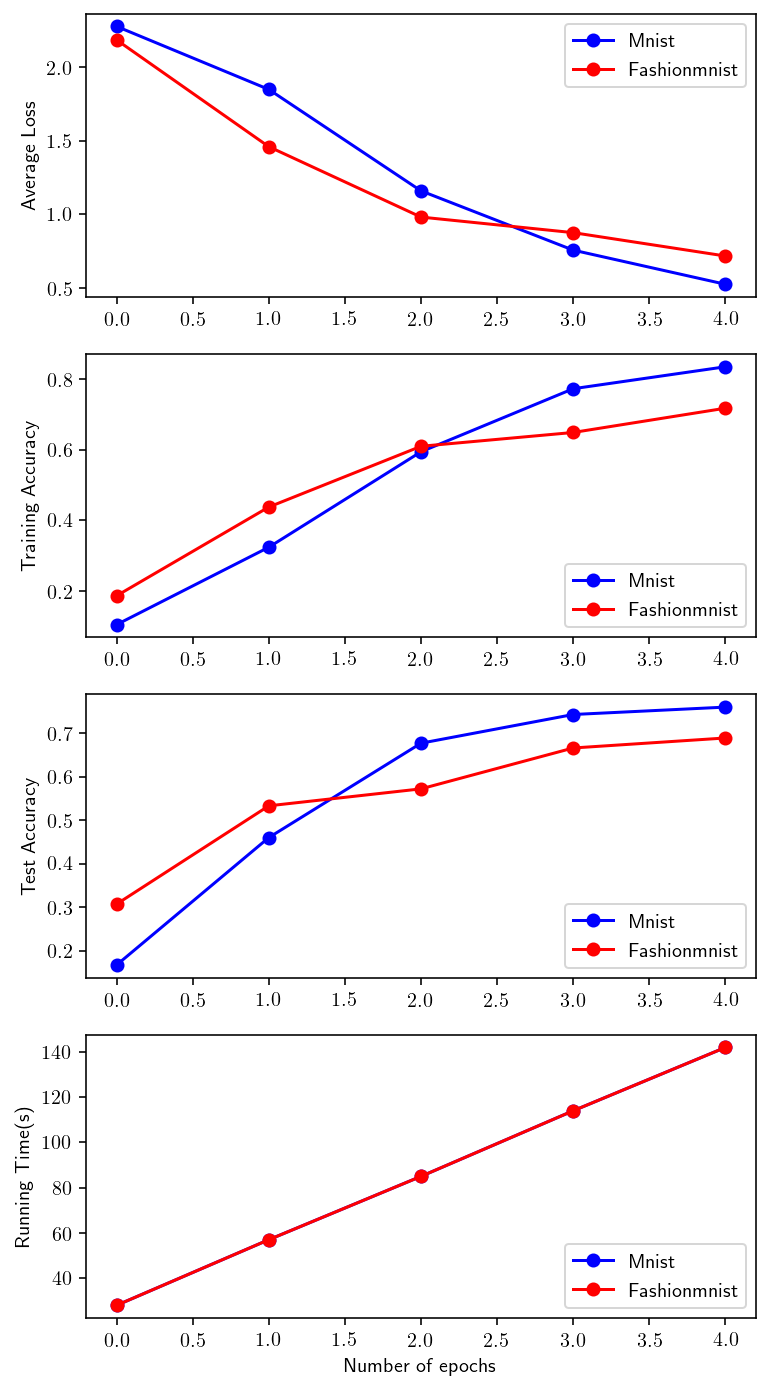

In [131]:
## Visualization
epoch_num = [range(len(i)) for i in RUN_TIME]
# fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7))
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=4, figsize=(6, 12))
# y2= 
# y2= 
ax0.plot(epoch_num[0], AVE_LOSS[0], 'bo-')
ax0.plot(epoch_num[1], AVE_LOSS[1], 'ro-')
ax1.plot(epoch_num[0], TRAIN_ACC[0], 'bo-')
ax1.plot(epoch_num[1], TRAIN_ACC[1], 'ro-')
ax2.plot(epoch_num[0], TEST_ACC[0], 'bo-')
ax2.plot(epoch_num[1], TEST_ACC[1], 'ro-')
ax3.plot(epoch_num[0], RUN_TIME[0], 'bo-')
ax3.plot(epoch_num[1], RUN_TIME[1], 'ro-')
# ax.plot(x, y2, 'ro--')
# ax.plot(x, y3, 'g.--', markersize=5)
# ax.plot(x, y4, 'y-', linewidth=2)
# ax.set_xlim(0, 7)
# ax.set_ylim(-1, 1.5)
# ax.set_xlabel(r'Running time')
ax3.set_xlabel(r'Number of epochs')
ax0.set_ylabel('Average Loss')
ax1.set_ylabel('Training Accuracy')
ax2.set_ylabel('Test Accuracy')
ax3.set_ylabel('Running Time(s)')
# ax0.set_title('Ave')
# ax.text(4, 0.4, r'$$')
ax0.legend(('Mnist','Fashionmnist'), loc='upper right')
ax1.legend(('Mnist','Fashionmnist'), loc='lower right')
ax2.legend(('Mnist','Fashionmnist'), loc='lower right')
ax3.legend(('Mnist','Fashionmnist'), loc='lower right')
fig.savefig('test.png', transparent=True, dpi=400)

In [ ]:
# Cifar
if num_channel == 3:
    size = [num_channel, batch_size, dim**2]
else:
    size = [batch_size, dim**2]
        
for inputs, labels in loaders['train']:
    inputs, labels = inputs.view(size), labels.data
    print(inputs.view(size))

In [ ]:
# GPU
# reference: https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor onto the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

########################################################################
# The rest of this section assumes that ``device`` is a CUDA device.
#
# Then these methods will recursively go over all modules and convert their
# parameters and buffers to CUDA tensors:
#
# .. code:: python
#
#     net.to(device)
#
#
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
#
# .. code:: python
#
#         inputs, labels = data[0].to(device), data[1].to(device)
#
# Why dont I notice MASSIVE speedup compared to CPU? Because your network
# is really small.
#
# **Exercise:** Try increasing the width of your network (argument 2 of
# the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
# they need to be the same number), see what kind of speedup you get.
#
# **Goals achieved**:
#
# - Understanding PyTorch's Tensor library and neural networks at a high level.
# - Train a small neural network to classify images
#
# Training on multiple GPUs
# -------------------------
# If you want to see even more MASSIVE speedup using all of your GPUs,
# please check out :doc:`data_parallel_tutorial`.
#
# Where do I go next?
# -------------------
#
# -  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
# -  `Train a state-of-the-art ResNet network on imagenet`_
# -  `Train a face generator using Generative Adversarial Networks`_
# -  `Train a word-level language model using Recurrent LSTM networks`_
# -  `More examples`_
# -  `More tutorials`_
# -  `Discuss PyTorch on the Forums`_
# -  `Chat with other users on Slack`_
#
# .. _Train a state-of-the-art ResNet network on imagenet: https://github.com/pytorch/examples/tree/master/imagenet
# .. _Train a face generator using Generative Adversarial Networks: https://github.com/pytorch/examples/tree/master/dcgan
# .. _Train a word-level language model using Recurrent LSTM networks: https://github.com/pytorch/examples/tree/master/word_language_model
# .. _More examples: https://github.com/pytorch/examples
# .. _More tutorials: https://github.com/pytorch/tutorials
# .. _Discuss PyTorch on the Forums: https://discuss.pytorch.org/
# .. _Chat with other users on Slack: https://pytorch.slack.com/messages/beginner/